## License 

Copyright 2019-2020 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

**DISCLAIMER:** This notebook is not legal compliance advice.

# Increase Fairness in Your Machine Learning Project with Disparate Impact Analysis using Python and H2O

#### Assess if your machine learning model is treating different groups of people similarly or differently

Fairness is an incredibly important, but highly complex entity. So much so that leading scholars have yet to agree on a strict definition. However, there is a practical way to discuss and handle *observational* fairness, or how your model predictions affect different groups of people. This procedure is often known as disparate impact analysis (DIA). DIA is far from perfect, as it relies heavily on user-defined thresholds and reference levels for disparity and does not attempt to remediate disparity or provide information on sources of disparity, but it is a fairly straightforward method to quantify your model’s behavior across sensitive demographic segments or other potentially interesting groups of observations. DIA is also an accepted, regulation-compliant tool for fair-lending purposes in the U.S. financial services industry. If it’s good enough for multibillion-dollar credit portfolios, it’s probably good enough for your project. 

This example DIA notebook starts by training a constrained, monotonic gradient boosting machine (GBM) classifier on the UCI credit card default data using the popular open source library, h2o. A probability cutoff for making credit decisions is selected by maximizing the F1 statistic and confusion matrices are generated to summarize the GBM’s decisions across male and female customers. A basic DIA procedure is then conducted using the information stored in the confusion matrices to calculate an adverse impact ratio. Several other disparity and parity metrics are calculated, and although it's abusing the technique, those will also be discussed and analyzed in the context of DIA.  

Because DIA really only considers groups of people, it's important to pair DIA with constrained models that can't treat similar people too differently. When using complex models with DIA, it's also important to look for any local, or individual, dicrimination that would not be flagged in the group quantities.

For an excellent and free reference on the topics of fairness and machine learning be sure to follow the book being written by Solon Barocas, Moritz Hardt and Arvind Narayanan: https://fairmlbook.org/. 

For Python fairness libraries that go far beyond the scope of this notebook see: 
* aequitas: https://github.com/dssg/aequitas
* AI Fairness 360: http://aif360.mybluemix.net/
* Themis: https://github.com/LASER-UMASS/Themis

#### Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and h2o will be used for modeling tasks. 

In [1]:
# imports

# h2o Python API with specific classes
import h2o                                        
from h2o.estimators.gbm import H2OGradientBoostingEstimator # for GBM
from h2o.grid.grid_search import H2OGridSearch 

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling
import shap          # for visualizing Shapley values

import matplotlib.pyplot as plt # general plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# display plots in-notebook
%matplotlib inline   

#### Start h2o
H2o is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 1, but the server still needs to be started.

In [2]:
h2o.init(max_mem_size='2G')       # start h2o
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\p\AppData\Local\Temp\tmpqxs24fup
  JVM stdout: C:\Users\p\AppData\Local\Temp\tmpqxs24fup\h2o_p_started_from_python.out
  JVM stderr: C:\Users\p\AppData\Local\Temp\tmpqxs24fup\h2o_p_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.3
H2O cluster version age:,4 months and 22 days !!!
H2O cluster name:,H2O_from_python_p_g8t6gq
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

Demographic variables will not be used as model inputs as is common in credit scoring models. However, demographic variables will be used after model training to test for disparate impact.

Because h2o accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`.

In [3]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles
The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other non-demographic input variables in the credit card default data except the row indentifier, `ID`.

In [4]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID', 'AGE', 'EDUCATION', 'MARRIAGE', 'SEX']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Helper function for recoding values in the UCI credict card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. These character values can be used directly in h2o decision tree models, and the function returns the original Pandas DataFrame as an h2o object, an H2OFrame. H2o models cannot run on Pandas DataFrames. They require H2OFrames.

In [5]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i])           
                
    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


#### Ensure target is handled as a categorical variable

In h2o, a numeric variable can be treated as numeric or categorical. The target variable `DEFAULT_NEXT_MONTH` takes on values of `0` or `1`. To ensure this numeric variable is treated as a categorical variable, the `asfactor()` function is used to explicitly declare that it is a categorical variable. 

In [6]:
data[y] = data[y].asfactor() 

#### Display descriptive statistics
The h2o `describe()` function displays a brief description of the credit card default data. Basic descriptive statistics are displayed for numeric inputs and the target. There are no missing values in this dataset.

In [7]:
data[X + [y]].describe()

Rows:30000
Cols:20




,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,10000.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,167484.32266666673,-0.016700000000000118,-0.1337666666666667,-0.16619999999999988,-0.2206666666666661,-0.26620000000000105,-0.2910999999999988,51223.33090000043,49179.07516666629,47013.154799999655,43262.94896666659,40311.40096666682,38871.76039999976,5663.580500000035,5921.163499999979,5225.681499999981,4826.076866666652,4799.387633333336,5215.50256666665,
maxs,1000000.0,8.0,8.0,8.0,8.0,8.0,8.0,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,129747.66156720246,1.1238015279973332,1.1971859730345495,1.1968675684465686,1.1691386224023357,1.1331874060027525,1.149987625607897,73635.86057552966,71173.76878252832,69349.38742703677,64332.856133916444,60797.15577026471,59554.1075367459,16563.28035402577,23040.87040205719,17606.96146980311,15666.159744032062,15278.305679144742,17777.46577543531,
zeros,0,14737,15730,15764,16455,16947,16286,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,20000.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,-1.0,2.0,0.0,0.0,0.0,2.0,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,0.0,0.0,0.0,0.0,0.0,0.0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


## 2. Train an H2O GBM classifier

#### Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [8]:
# split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


#### Establish monotonicity constraints based on Pearson correlation
In general for high-stakes situations, it's best to use constrained machine learning models. Constrained models are easier to explain and to test for disparate impact. (Constrained models may also generalize better in low signal-to-noise scenarios.) Very complex models may be nearly impossible to test for disparate impact, as they can treat similar individuals quite differently, making it possible for local instances of discrimination to occur and not be detected by disparate impact testing. 

This GBM model will be constrained using the pairwise Pearson correlation between the inputs and the targets to establish the direction of the monotonicity constraints. H2o expects a dictionary with input variable names as keys and values of 1 for a positive monotonic constrain, 0 for no constraint, and -1 for a negative monotonic constraint.

In [9]:
# display Pearson correlation between inputs and targets
print(pd.DataFrame(test.as_data_frame()[X + [y]].corr()[y]).iloc[:-1])

# positive Pearson correlation w/ P_DEFAULT_NEXT_MONTH == positive constraint == 1
# negative Pearson correlation w/ P_DEFAULT_NEXT_MONTH == negative constraint == -1
names = list(test.as_data_frame()[X + [y]].corr()[y].index)[:-1]
signs = list([int(i) for i in np.sign(test.as_data_frame()[X + [y]].corr()[y].values[:-1])])

mc = {}
for i, name in enumerate(names):
    mc[name] = signs[i]

print('\n', mc)

           DEFAULT_NEXT_MONTH
LIMIT_BAL           -0.151732
PAY_0                0.318419
PAY_2                0.250650
PAY_3                0.220672
PAY_4                0.201708
PAY_5                0.193368
PAY_6                0.183716
BILL_AMT1           -0.023252
BILL_AMT2           -0.019563
BILL_AMT3           -0.021105
BILL_AMT4           -0.018092
BILL_AMT5           -0.012072
BILL_AMT6           -0.011350
PAY_AMT1            -0.085398
PAY_AMT2            -0.062419
PAY_AMT3            -0.069603
PAY_AMT4            -0.055825
PAY_AMT5            -0.051942
PAY_AMT6            -0.047694

 {'LIMIT_BAL': -1, 'PAY_0': 1, 'PAY_2': 1, 'PAY_3': 1, 'PAY_4': 1, 'PAY_5': 1, 'PAY_6': 1, 'BILL_AMT1': -1, 'BILL_AMT2': -1, 'BILL_AMT3': -1, 'BILL_AMT4': -1, 'BILL_AMT5': -1, 'BILL_AMT6': -1, 'PAY_AMT1': -1, 'PAY_AMT2': -1, 'PAY_AMT3': -1, 'PAY_AMT4': -1, 'PAY_AMT5': -1, 'PAY_AMT6': -1}


#### Train h2o GBM classifier with monotonicity constraints
Many tuning parameters must be specified to train a GBM using h2o. Typically a grid search would be performed to identify the best parameters for a given modeling task using the `H2OGridSearch` class. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the h2o GBM using the `seed` parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `stopping_rounds` parameter is used to stop the training process after the test error fails to decrease for 5 iterations. Monotonicity constraints are passed to the GBM using the `monotone_constraints` parameter.

In [10]:
# initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,              # maximum 150 trees in GBM
                                     max_depth=4,             # trees can have maximum depth of 4
                                     sample_rate=0.9,         # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,     # use 90% of variables in each iteration (tree)
                                     #balance_classes=True,   # sample to balance 0/1 distribution of target - can help LOCO
                                     stopping_rounds=5,       # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1,   # for reproducibility, set higher for bigger data
                                     monotone_constraints=mc, # enforces monotonicity wrt each input
                                     model_id='dia_gbm',      # for locating the model in Flow UI 
                                     seed=12345)              # for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

# uncomment to see model details
# print(model) 

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.77


#### Display Shapley variable importance
Shapley values are a locally-accurate and globally consistent variable importance metric. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be calculated and aggregated below to get a more holistic and consisent measurement for the global importance of each input variable. 

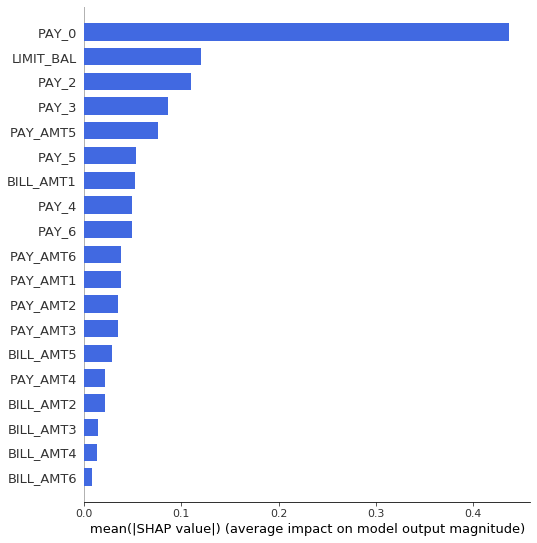

In [11]:
contributions = model.predict_contributions(test)
contributions_matrix = contributions.as_data_frame().values
shap_values = contributions_matrix[:,:-1]
shap.summary_plot(shap_values, X, plot_type='bar', color='royalblue')

Repayment `PAY_*` variables appear to be most important in this model along with a credit limit, `LIMIT_BAL`.

(In a more realistic scenario, credit limit would likely not be used as a model input because it could cause target leakage. It's used here in this small data example to improve model accuracy.)

# 3. Select a Probability Cutoff by Maximizing F1 Statistic

#### Bind model predictions to test data for further calculations
Model predictions will be used in numerous subsequent calculations.

In [12]:
# cbind predictions to training frame
# give them a nice name
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = test['ID'].cbind(model.predict(test).drop(['predict', 'p0']))
preds1.columns = ['ID', yhat]
test_yhat = test.cbind(preds1[yhat]).as_data_frame()
test_yhat.reset_index(drop=True, inplace=True) # necessary for later searches/joins

gbm prediction progress: |████████████████████████████████████████████████| 100%


#### Function to calculate PR-AUC Curve

Predictive models often produce probabilities, not decisions. So to make a decision with a model-generated predicted probability for any one customer, you must specify a numeric cutoff above which we say a customer will default and below which we say they will not default. Cutoffs play a crucial role in DIA as they impact the underlying measurements used to calculate diparity. In fact, tuning cutoffs carefully is a potential remdiation tactic for any discovered disparity. There are many accepted ways to select a cutoff (besides simply using 0.5) and in this notebook the cutoff will be selected by striking a balance between the model's recall (true positive rate) and it's precision using the F1 statistic. Using precision and recall to select a cutoff is sometimes seen as more robust to imbalanced data than the standard ROC approach. Maximizing F1 typically results in a good balance between sensitivity and precision. 

Selecting a cutoff can be done intervactively with h2o Flow as well. Enter the url: http://localhost:54321/flow/index.html (or your H2O Connection URL displayed in cell 2) into your browser. Select `Models` -> `List all models` -> `dia_gbm` and you should see an interactive ROC curve where you can pick your own cutoff.

To learn more about confusion matrices see: https://en.wikipedia.org/wiki/Confusion_matrix.

**Note:** h2o supports `pr_auc` directly: http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/metrics.html#h2o.model.metrics_base.MetricsBase.pr_auc. This utility function is used here to give more control over the plotting of the PR curve below.

In [13]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prauc_frame
        
prauc_frame = get_prauc(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH')

#### Select best cutoff

In [14]:
best_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
### !!! UNCOMMENT LINES BELOW TO REMEDIATE MINOR FAIRNESS ISSUES !!! ###
# best_cut = 0.3  # min threshold with overall fairness
# best_cut = 0.46 # max accuracy
# best_cut = 0.35 # max MCC
print('%.2f' % best_cut)

0.27


#### Plot PR-AUC Curve

An area under the curve for precision and recall (PR-AUC) plot is a typical way to visualize recall and precision for a predictive model. The F1 statistic is the harmonic mean of recall and precision, and we can visualize where F1 is maximized on with the AUC-PR curve.

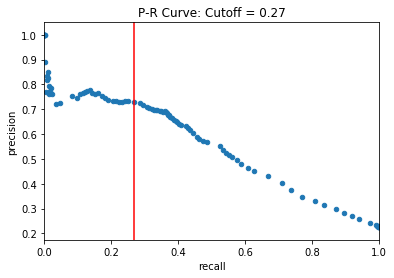

In [15]:
# Plot P-R AUC w/ best cutoff
title_ = 'P-R Curve: Cutoff = ' + str(best_cut)
ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

In h2o Flow a traditional ROC curve is displayed, in which true positive rate is plotted against false positive rate. You can still use h2o Flow and the traditional ROC curve to verify that F1 is maximized at a probability cutoff of ~ 0.27.

# 4. Report Raw Confusion Matrices

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the GBM's behavior in general and across men and women.

#### Function to print confusion matrices by an input variable

In [16]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
    
get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', cutoff=best_cut)

Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1051,859
predicted: 0,952,6078


The general confusion matrix shows that the GBM is more accurate than not because the true positive and true negative cells contain the largest values by far. But the GBM seems to make a larger number of type II errors or false negative predictions. False negatives can be a disparity issue, because for complex reasons, many credit scoring and other models tend to over-estimate the likelihood of non-reference groups - typically people other than white males - to default. This is both a sociological fairness problem and a financial problem if an unpriviledged group is not recieving the credit they deserve, in favor of undeserving white males. Deserving people miss out on potentially life-changing credit and lenders incur large write-off costs.

#### Report confusion matrices by `SEX`

The only values for `SEX` in the dataset are `female` and `male`. 

In [17]:
sex_levels = list(test_yhat['SEX'].unique())
sex_levels

['female', 'male']

#### Confusion matrix for `SEX = male`

In [18]:
male_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='SEX', level='male', cutoff=best_cut)
male_cm

Confusion matrix by SEX=male


,actual: 1,actual: 0
predicted: 1,453,345
predicted: 0,418,2261


#### Confusion matrix for `SEX = female`

In [19]:
female_cm = get_confusion_matrix(test_yhat, 'DEFAULT_NEXT_MONTH', 'p_DEFAULT_NEXT_MONTH', by='SEX', level='female', cutoff=best_cut)
female_cm

Confusion matrix by SEX=female


,actual: 1,actual: 0
predicted: 1,598,514
predicted: 0,534,3817


Both confusion matrices reflect the global confusion matrix: more accurate than not with a larger number of false negative predictions (type II errors) than false positive predictions (type I errors).

# 6. Disparate Impact Analysis (DIA)

To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the GBM's overall performance and how it behaves when predicting:

* Default correctly
* Non-default correctly
* Default incorrectly (type I errors)
* Non-default incorrectly (type II errors)

In a real-life lending scenario, type I errors essentially amount to false accusations of financial impropriety and type II errors result in awarding loans to undeserving customers. Both types of errors can be costly to the lender too. Type I errors likely result in lost interest and fees. Type II errors often result in write-offs.

#### Dictionary of metrics used to assess disparity and parity

In [20]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
#'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}    

#### Utility function to translate metrics into Pandas statements

In [21]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression


#### Calculate and report metrics
This nested loop calculates all the metrics defined above for men and women.

In [22]:
# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'male': male_cm, 
           'female': female_cm} 

metrics_frame = pd.DataFrame(index=sex_levels) # frame for metrics

# nested loop through:
# - sex levels
# - metrics 
for level in sex_levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])

        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

,Adverse Impact,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
female,0.203551,0.808164,0.528269,0.537770,0.881321,0.877270,0.118679,0.462230,0.471731,0.122730
male,0.229508,0.780558,0.520092,0.567669,0.867613,0.843972,0.132387,0.432331,0.479908,0.156028


From eyeballing the raw metrics it appears that the model is treating men and women roughly similarly as groups. (These metrics do not indicate very much about specific, individual cases of bias, but only give information for the groups as a whole.)

#### Plot false omissions rate by `SEX`

Because the confusion matrices indicated there might be a problem with non-default predictions, false omissions rate will be examined closely. False omissions measures how many customers the model predicted *incorrectly* would not default, out of the customers in the group the model *predicted* would not default. (Of course other metrics are important from a fairness and business perspective. For an excellent in-depth discussion and example regarding numerous disparity metrics, see: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)

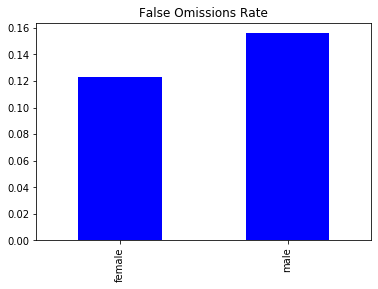

In [23]:
_ = metrics_frame['False Omissions Rate'].plot(kind='bar', color='b', title='False Omissions Rate')

#### Calculate and report disparity
To calculate disparity we compare the confusion matrix for each sex to the metrics for a user-defined reference level and to user-defined thresholds. In this case, we take the class of people who seem most priviledged as the reference level, i.e. `SEX = male`. (Usually the reference level would be `race = white` or `sex = male`.) According to the four-fifths rule (https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) thresholds are set such that metrics 20% lower or higher than the reference level metric will be flagged as disparate. **Technically, the four-fifths rule only applies to the adverse impact ratio, or "adverse impact disparity" below, but it will be applied to all other displayed metric as a rule of thumb.**

In [24]:
ref_level = 'male' # user-defined reference level

parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=sex_levels)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)

,Adverse Impact Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
female,0.886901,1.03537,1.01572,0.94733,1.0158,1.03945,0.896459,1.06916,0.982962,0.78659
male,1,1,1,1,1,1,1,1,1,1


For the selected thresholds, the GBM appears to have only one value for metrics that is low out-of-range, false omissions rate. According to the more common and accepted test of `0.8 < Adverse Impact Disparity < 1.25` this model could be considered to be free from disparate impact w.r.t to `SEX`. However, the flagged false omissions rate disparity indicates males may be receiving too many loans they cannot pay back, potentially preventing females from recieving these loans.

#### Plot false omissions rate disparity

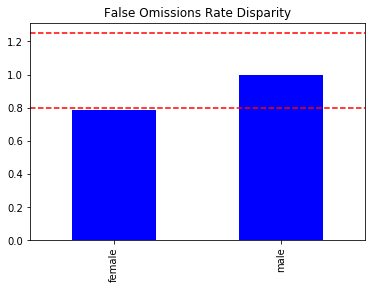

In [25]:
ax = disp_frame['False Omissions Rate Disparity'].plot(kind='bar', color='b', title='False Omissions Rate Disparity')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')

#### Assess and report parity
A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

* Type I Parity: Fairness in both FDR Parity and FPR Parity
* Type II Parity: Fairness in both FOR Parity and FNR Parity
* Equalized Odds: Fairness in both FPR Parity and TPR Parity
* Supervised Fairness: Fairness in both Type I and Type II Parity
* Overall Fairness: Fairness across all parities for all metrics

In [26]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=sex_levels, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(sex_levels):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all metrics
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
par_frame.loc['all', :] = par_frame.all(axis='index')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)

,Adverse Impact Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
female,True,True,True,True,True,True,True,True,True,False,True,False,True,False,False
male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
all,True,True,True,True,True,True,True,True,True,False,True,False,True,False,False


Importantly, the GBM appears to have adverse impact parity, and many other types of positive parity characteristics. However, the model is still suffering from a minor disparity problem due to it's propensity to make false negative predictions for males. To address such bias users could tune the GBM cutoff or regularization, could try new methods for reweighing data prior to model training, try new modeling methods specifically designed for fairness, or post-process the decisions. Checkout the IBM AIF360 package for some of these techniques: http://aif360.mybluemix.net/. Before attempting remediation here, local, or individual, fairness will also be investigated. 

# 7. Traditional Fair Lending Measures

Along with adverse impact disparity (i.e., adverse impact ratio or AIR) several measures have long-standing legal precedence in fair lending. Two of these measures are known as marginal effect and standardized mean difference. 

#### Simple function to calculate marginal effect
Marginal effect describes the difference between the percent of the reference group awarded a loan and the percent of the protected group awarded a loan under a model. 

In [27]:
def marginal_effect(reference, protected):

    """ Calculates the marginal effect as a percentage difference between a reference and 
        a protected group: reference_percent - protected_percent. Prints intermediate values. 
        Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        Marginal effect as a formatted string. 
        
    """
    
    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1])
    reference_total = float(cm_dict[reference].sum().sum())
    reference_percent = 100*(reference_accepted/reference_total)
    print(reference.title() + ' accepted: %.2f%%' % reference_percent)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1])
    protected_total = float(cm_dict[protected].sum().sum())
    protected_percent = 100*(protected_accepted/protected_total)
    print(protected.title() + ' accepted: %.2f%%' % protected_percent)
    
    # return marginal effect
    return 'Marginal effect: %.2f%%' % (reference_percent - protected_percent)

print(marginal_effect('male', 'female'))

Male accepted: 77.05%
Female accepted: 79.64%
Marginal effect: -2.60%


About 77% of men are awarded a loan by the model. About 79.6% of women are awarded a loan. This results in a marginal effect of -2.60%. Given that the marginal effect is negative, indicating that a higher percentage of individuals in the protected group were awarded a loan than in the reference group, this value would likely not indicate a discrimination problem in most scenarios. The magnitude of the marginal effect is also relatively small, another sign that discrimination concerning SEX is low under the model. Generally, larger marginal effects may be tolerated in newer credit products, whereas smaller marginal effects are expected in established credit products.

#### Standardized mean difference
The standardized mean difference (SMD), i.e. Cohen's D, is the mean value of the prediction for the protected group minus the mean prediction for the reference group, all divided by the standard deviation of the prediction. Like AIR, SMD has some prescribed thresholds: 0.2, 0.5, and 0.8 for small, medium, and large differences, respectively. The standardized mean difference can also be used on continuous values like credit limits or loan amounts.

In [28]:
def smd(frame, yhat, j, reference, protected):
    
    """ Calculates standardized mean difference between a protected and reference group:
    (mean(yhat | j=protected) - mean(yhat | j=reference))/sigma(yhat). 
    Prints intermediate values. 
    
    Args:
        frame: Pandas dataframe containing j and predicted (yhat) values.
        yhat: Name of predicted value column.
        j: name of demographic column containing reference and protected group labels. 
        reference: name of reference group in j.
        protected: name of protected group in j. 

    Returns:
       Standardized mean difference as a formatted string.
       
    """
    
    # yhat mean for j=reference
    reference_yhat_mean = frame[frame[j] == reference][yhat].mean()
    print(reference.title() + ' mean yhat: %.2f' % reference_yhat_mean)
    
    #yhat mean for j=protected 
    protected_yhat_mean = frame[frame[j] == protected][yhat].mean()
    print(protected.title() + ' mean yhat: %.2f' % protected_yhat_mean)
    
    # std for yhat
    sigma = frame[yhat].std()
    print(yhat.title() + ' std. dev.:  %.2f' % sigma)
    
    return 'Standardized Mean Difference: %.2f' % ((protected_yhat_mean - reference_yhat_mean)/sigma)
    
print(smd(test_yhat, 'p_DEFAULT_NEXT_MONTH', 'SEX', 'male', 'female'))

Male mean yhat: 0.22
Female mean yhat: 0.21
P_Default_Next_Month std. dev.:  0.18
Standardized Mean Difference: -0.08


For this model, in the test set, men receive a higher average probability of default than do women. This difference is evident even after standardizing with the standard deviation of the predictions. However, the difference is quite small, below the 0.2 threshold for a small difference. SMD also points to low disparity between men and women under this model.

## 8. Investigate Individual Disparity 

In nonlinear models, similar people can be treated differenly by the model, so even if the model is mostly fair for most kinds of people, there could still be people the model treated unfairly. This could occur for multiple reasons, including the functional form of the learned model or because different variables are combined by the model to represent strong signals. If a variable is important in a dataset, model, or problem domain it's likely that a nonlinear model will find combinations of other variables to act as proxies for the problematic variable -- potentially even different combinations for different rows of data! So by simply testing for group fairness, you may miss instances of individual discrimination.

#### Augment predictions with decisions and logloss residuals for women with false positive predictions
In this notebook, residuals for false positive predictions for women will be examined in an attempt to locate any individual instances of model discrimination. These are women who the model said would default, but they did not default. So they may have experienced some discrimination under the model.

In [29]:
test_yhat_female = test_yhat[test_yhat['SEX'] == 'female'].copy(deep=True)


test_yhat_female['d_DEFAULT_NEXT_MONTH'] = 0
test_yhat_female.loc[test_yhat_female[yhat] > best_cut, 'd_DEFAULT_NEXT_MONTH'] = 1

test_yhat_female['r_DEFAULT_NEXT_MONTH'] = -test_yhat_female[y]*np.log(test_yhat_female[yhat]) -\
                       (1 - test_yhat_female[y])*np.log(1 - test_yhat_female[yhat]) 
    
test_yhat_female_fp = test_yhat_female[(test_yhat_female[y] == 0) &\
                                       (test_yhat_female['d_DEFAULT_NEXT_MONTH'] == 1)]

#### Plot logloss redisuals
There are clear high-magnitude outliers in the logloss residuals for women who were issued false positive predictions. Given that those people were the people the model was most wrong about, those predictions will be checked first, just in case something very strange happened.

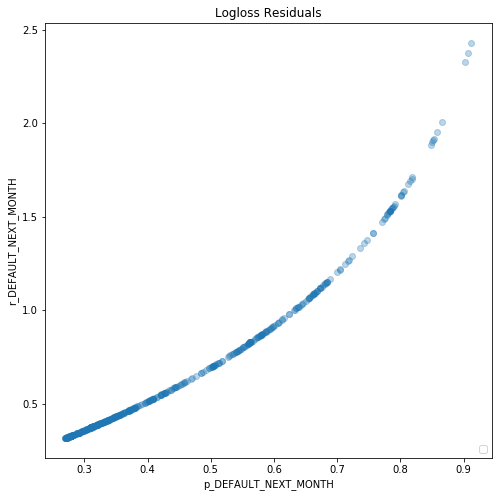

In [30]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

ax_.plot(test_yhat_female_fp[yhat],
         test_yhat_female_fp['r_DEFAULT_NEXT_MONTH'],
         marker='o', linestyle='', alpha=0.3)

# annotate plot
_ = plt.xlabel(yhat)
_ = plt.ylabel('r_DEFAULT_NEXT_MONTH')
_ = ax_.legend(loc=4)
_ = plt.title('Logloss Residuals')

#### Examine top 3 outlying individuals

In [31]:
test_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).head(n=3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,d_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
1760,5916,110000,female,graduate school,married,41,2,2,7,7,7,7,150,150,150,150,150,150,0,0,0,0,0,0,0,0.911895,1,2.429222
929,3087,30000,female,university,single,24,2,2,7,7,7,7,300,300,300,300,300,300,0,0,0,0,0,0,0,0.907065,1,2.375853
5731,19316,110000,female,graduate school,married,41,3,2,2,7,7,7,150,150,150,150,150,150,0,0,0,0,0,0,0,0.902306,1,2.325911


Looking at the top 3 highest residual predictions, it's clear these were customers with a horrible payment track record that somehow were able to make a last-minute payment. Although it's not possible to say they were not discrimated against by the model, it seems very clear that the model was justified to issue default predictions for these women. 

#### Adverse Action Notices 
Anyone that is denied further credit due to this model in the U.S. must be given reasons why. Shapley values provide a mechanism to rank the contributions of input variables to any given model decision and may be suitable for adverse action notice generation. Because the highest residual false positive female seems like a probable candidate to be rejected for further credit at some point, Shapley values can be used to say why according to this model.

Sum of Shapley contributions and bias: 2.3369910083711147
Model prediction in margin space: 2.336991189841194


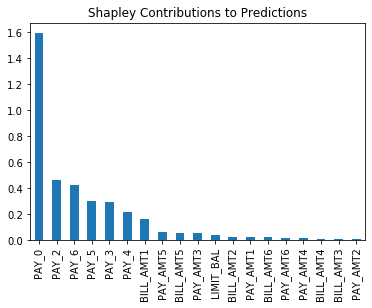

In [32]:
# select highest residual female false positive
row = test_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).head(n=1)

# search for her index in shap_values array
# create Pandas DataFrame and plot
s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(len(X), 1), columns=['Reason Codes'], index=X)
_ = s_df.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')

# check that Shapley is locally accurate
print('Sum of Shapley contributions and bias:', s_df.sum()[0] + contributions_matrix[0, -1])
print('Model prediction in margin space:', np.log(row[yhat].values/(1 - row[yhat].values))[0])

Combining the Shapley values with the individual's data values allows ranked reasons to be given for denial of credit:

1. Two months late on most recent payment
2. Two months late on second most recent payment
3. Seven months late on sixth most recent payment

Because monotonicity contraints were used during model training, these reasons should be consistent across all denial decisions meaning that no one who was denied credit would have a better value for an input variable than someone who was granted credit.

#### Examine low logloss residual individuals

Given that high-residual individuals were not clearly discriminated against, their low-residual counter parts could be interesting to investigate next.

In [33]:
test_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=True).head(n=150)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,d_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
5869,19776,110000,female,university,married,42,0,0,0,2,2,0,5174,6184,8383,8394,7709,8084,1106,2393,300,0,500,500,0,0.270166,1,0.314938
2959,9916,20000,female,graduate school,single,24,-1,-1,-2,-2,-2,-2,379,0,0,0,0,0,0,0,0,0,0,0,0,0.270243,1,0.315044
3508,11755,160000,female,university,single,27,1,-2,-1,0,0,-2,0,0,6204,6204,0,0,0,6204,0,0,0,0,0,0.270293,1,0.315112
321,1057,190000,female,graduate school,single,33,1,2,0,0,0,0,115056,108137,89722,69861,49894,49727,0,4413,2942,2000,1583,1500,0,0.271024,1,0.316114
8353,28028,240000,female,university,married,32,1,-2,-2,-1,-1,-1,0,0,0,262,0,1389,0,0,262,0,1389,0,0,0.271053,1,0.316154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,8625,80000,female,graduate school,single,25,1,-2,-1,-1,-2,-2,0,0,300,0,0,0,0,300,0,0,0,500,0,0.311165,1,0.372754
3227,10827,120000,female,graduate school,single,34,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.311165,1,0.372754
2246,7517,80000,female,graduate school,single,52,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.311165,1,0.372754
3292,11040,110000,female,university,married,48,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.311165,1,0.372754


Examing the low-residual false positives, it can be seen that perhaps the F1-selected cutoff is a bit too conservative. Many women just above the cutoff have missed 0-2 payments, and only been late 1-2 months on the few payments they missed, if any. This potential bias problem can be remediated by increasing the cutoff in cell 14.

#### Shutdown H2O
After using h2o, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any h2o data structures, such as models and H2OFrames, or scoring artifacts, such as POJOs and MOJOs.

In [34]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_9c75 closed.


#### Conclusion

This notebook outlines a basic approach to DIA (and over-generalizes that phrase). In a complex, real-world machine learning project the hard-to-define phenomenas of sociological bias and unfairness can materialize in many ways and from many different sources. Although far from a flawless technique, the beauty of DIA is it is straightforward to implement, functions in a model-agnostic fashion on known labels and model predictions, and is applied in complex real-world fair lending situations, so it can probably be applied to your model too! 

Why risk being called out in the media for training an unfair model? Or why not investigate the monetary opportunity costs of type I errors and potential losses from type II errors? Why not do the right thing and investigate how your model treats people?